## Importing Libraries

In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Uploading Cleaned Dataset

In [31]:
data=pd.read_csv(r"Forestcover_cleaneddata.csv")

In [32]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type,dist_water_road_ratio,dist_water_fire_ratio,hillshade_diff_morning_noon,hillshade_diff_noon_afternoon,elevation_slope_interaction
0,2596.0,51,3,258.0,0,510,221.0,232,148,6279,...,0.0,0.0,0.0,0.0,0,0.504892,0.041083,-11.0,84,7788.0
1,2590.0,56,2,212.0,-6,390,220.0,235,151,6225,...,0.0,0.0,0.0,0.0,0,0.542199,0.034051,-15.0,84,5180.0
2,2804.0,139,9,268.0,65,3180,234.0,238,135,6121,...,0.0,0.0,0.0,0.0,4,0.084250,0.043777,-4.0,103,25236.0
3,2785.0,155,18,242.0,117,3090,238.0,238,122,6211,...,0.0,0.0,0.0,0.0,4,0.078292,0.038957,0.0,116,50130.0
4,2595.0,45,2,153.0,-1,391,220.0,234,150,6172,...,0.0,0.0,0.0,0.0,0,0.390306,0.024785,-14.0,84,5190.0


## Creating X and y

In [34]:
X = data[selected_features]
y = data["Cover_Type"]

print("Data shape:", data.shape)
print("Feature shape:", X.shape, "Target shape:", y.shape)

Data shape: (145890, 60)
Feature shape: (145890, 15) Target shape: (145890,)


## Train-Test Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (116712, 15) (116712,)
Test: (29178, 15) (29178,)


## Feature Importance using Random Forest (Feature Selection)

In [36]:
rf_temp = RandomForestClassifier(n_estimators=300, random_state=42)
rf_temp.fit(X_train, y_train)

feature_importance_df = pd.DataFrame({
    "Feature": selected_features,
    "Importance": rf_temp.feature_importances_
}).sort_values(by="Importance", ascending=False)

In [37]:
selected_features = feature_importance_df.head(15)["Feature"].tolist()
selected_features

['Elevation',
 'Horizontal_Distance_To_Roadways',
 'Horizontal_Distance_To_Fire_Points',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Aspect',
 'Hillshade_3pm',
 'Hillshade_Noon',
 'Slope',
 'Soil_Type_29',
 'Soil_Type_25',
 'Soil_Type_27',
 'Soil_Type_26',
 'Soil_Type_21',
 'Soil_Type_24']

In [38]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print("Train (selected features):", X_train.shape)
print("Test (selected features):", X_test.shape)

Train (selected features): (116712, 15)
Test (selected features): (29178, 15)


In [39]:
numeric_features = [
    'Elevation',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Aspect',
    'Hillshade_3pm',
    'Hillshade_Noon',
    'Slope'
]

categorical_features = [
    'Soil_Type_29',
    'Soil_Type_25',
    'Soil_Type_27',
    'Soil_Type_26',
    'Soil_Type_21',
    'Soil_Type_24'
]

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))


Numeric features: 9
Categorical features: 6


# Scaling

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features)

In [45]:
X_train_final = pd.concat(
    [X_train_scaled.reset_index(drop=True),
     X_train[categorical_features].reset_index(drop=True)],
    axis=1
)

In [46]:
X_test_final = pd.concat(
    [X_test_scaled.reset_index(drop=True),
     X_test[categorical_features].reset_index(drop=True)],
    axis=1
)
print("Final X_train for models:", X_train_final.shape)
print("Final X_test for models:", X_test_final.shape)

Final X_train for models: (116712, 15)
Final X_test for models: (29178, 15)


## SMOTE FOR CLASS IMBALANCE

In [47]:
sm = SMOTE(random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train_final, y_train)

print("Before SMOTE:", dict(zip(*np.unique(y_train, return_counts=True))))
print("After SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))
print("Resampled X:", X_train_res.shape, "Resampled y:", y_train_res.shape)

Before SMOTE: {np.int64(0): np.int64(2455), np.int64(1): np.int64(1728), np.int64(2): np.int64(1728), np.int64(3): np.int64(1728), np.int64(4): np.int64(82457), np.int64(5): np.int64(1728), np.int64(6): np.int64(24888)}
After SMOTE: {np.int64(0): np.int64(82457), np.int64(1): np.int64(82457), np.int64(2): np.int64(82457), np.int64(3): np.int64(82457), np.int64(4): np.int64(82457), np.int64(5): np.int64(82457), np.int64(6): np.int64(82457)}
Resampled X: (577199, 15) Resampled y: (577199,)


# BUILD MODELS

In [48]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

In [53]:
results = {}

for name, model in models.items():
    if name in ["Logistic Regression", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test_final)

    results[name] = accuracy_score(y_test, y_pred)
results

{'Logistic Regression': 0.8128041675234766,
 'KNN': 0.897182808965659,
 'Decision Tree': 0.9222359311810268,
 'Random Forest': 0.9471519638083488,
 'XGBoost': 0.9013640414010556}

# CROSS-VALIDATION FOR ALL MODELS

In [19]:
cv_results = {}

for name, model in models.items():
    X_used = X_train_scaled if name in ["Logistic Regression", "KNN"] else X_train_res
    scores = cross_val_score(model, X_used, y_train_res, cv=5)
    cv_results[name] = scores.mean()

cv_results

{'Logistic Regression': np.float64(0.6809401953380807),
 'KNN': np.float64(0.970855807230126),
 'Decision Tree': np.float64(0.9822608886771128),
 'Random Forest': np.float64(0.9915869598807774),
 'XGBoost': np.float64(0.9667549751790563)}

# HYPERPARAMETER TUNING
# Logistic Regression

In [20]:
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"]
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=2000), param_grid_lr, cv=5)
grid_lr.fit(X_train_scaled, y_train_res)
best_lr = grid_lr.best_estimator_
pickle.dump(best_lr, open("best_lr.pkl", "wb"))

## KNN 

In [21]:
param_grid_knn = {
    "n_neighbors": range(3, 31),
    "weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_knn.fit(X_train_scaled, y_train_res)
best_knn = grid_knn.best_estimator_
pickle.dump(best_knn, open("best_knn.pkl", "wb"))

# Decision Tree

In [22]:
param_grid_dt = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(3, 40),
    "min_samples_split": [2, 5, 10]
}

grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
grid_dt.fit(X_train_res, y_train_res)
best_dt = grid_dt.best_estimator_
pickle.dump(best_dt, open("best_dt.pkl", "wb"))

# Random Forest

In [23]:
rf_params = {
    "n_estimators": np.arange(200, 600),
    "max_depth": np.arange(10, 60),
    "min_samples_split": [2, 5, 10],
}

rand_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    n_iter=20,
    cv=5,
    random_state=42
)

rand_rf.fit(X_train_res, y_train_res)
best_rf = rand_rf.best_estimator_
pickle.dump(best_rf, open("best_rf.pkl", "wb"))

# XGBoost

In [24]:
xgb_params = {
    "max_depth": np.arange(3, 12),
    "learning_rate": np.linspace(0.01, 0.3, 20),
    "n_estimators": np.arange(200, 600)
}

rand_xgb = RandomizedSearchCV(
    XGBClassifier(eval_metric='mlogloss'),
    xgb_params,
    n_iter=20,
    cv=5,
    random_state=42
)

rand_xgb.fit(X_train_res, y_train_res)
best_xgb = rand_xgb.best_estimator_
pickle.dump(best_xgb, open("best_xgb.pkl", "wb"))

In [4]:
best_lr = pickle.load(open("best_lr.pkl", "rb"))
best_knn = pickle.load(open("best_knn.pkl", "rb"))
best_dt = pickle.load(open("best_dt.pkl", "rb"))
best_rf = pickle.load(open("best_rf.pkl", "rb"))
best_xgb = pickle.load(open("best_xgb.pkl", "rb"))

print("All tuned models loaded successfully!")

All tuned models loaded successfully!


## Final Evaluation of Tuned Models

In [17]:
final_models = {
    "Logistic Regression": best_lr,
    "KNN": best_knn,
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

final_results = {}

for name, model in final_models.items():
    if name in ["Logistic Regression", "KNN"]:
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)

    final_results[name] = accuracy_score(y_test, y_pred)

final_results

{'Logistic Regression': 0.5558982795256701,
 'KNN': 0.9003358694907122,
 'Decision Tree': 0.9378984166152581,
 'Random Forest': 0.953149633285352,
 'XGBoost': 0.9609637398039619}

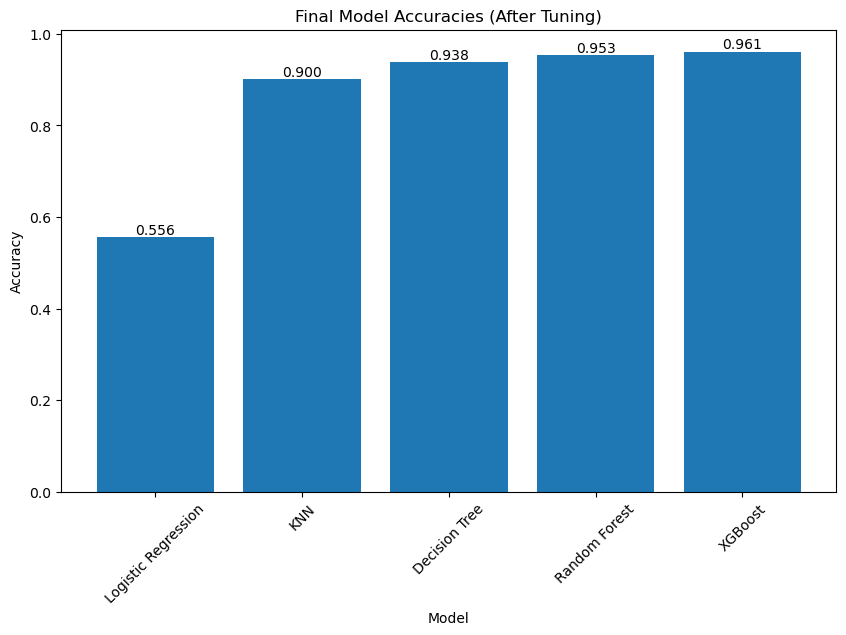

In [30]:
plt.figure(figsize=(10,6))
bars = plt.bar(final_results.keys(), final_results.values())
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,   
        height,                            
        f"{height:.3f}",                   
        ha='center', va='bottom', fontsize=10
    )

plt.title("Final Model Accuracies (After Tuning)")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()

## Saving the Best Model

In [54]:
processed = {
    "scaler": scaler,
    "selected_columns": selected_features
}

with open("Processed_Data.pkl", "wb") as f:
    pickle.dump(processed, f)

print("✅ Saved Processed_Data.pkl successfully!")

✅ Saved Processed_Data.pkl successfully!


In [55]:
best_model_name = max(final_results, key=final_results.get)
best_model = final_models[best_model_name]

with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

best_model_name

'XGBoost'